In [1]:
from __future__ import print_function

# import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv1D, LSTM,\
                         Bidirectional, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from google.colab import drive
import os

from numpy.random import seed
seed(1)



Using TensorFlow backend.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
print('import loaded.')

#Settings
NUM_TWEET = 10000 # number of tweets of positive and negative tweets respectively, 
NUM_WORDS = 15000 # the maximum number of words to keep, based on word frequency.
GLOVE_DIM = 300 # determine the feature dimension of the embedding matrix
BATCH_SIZE = 256
MAX_LEN = 40 # time steps





import loaded.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#load data
def load_data(name, r, file_path = '/content/drive/My Drive/Project_/data/preprocessed/'):
    """
    load saved preprocessed data
    name: string, type (tweet or labels)
    r: int, day range the data covered
    """
    from pickle import load
    with open('_'.join([file_path, name, str(r)])+ '.pkl','rb') as file:
        data = load(file)
    return data


data = load_data('tweet', NUM_TWEET)
labels = load_data('labels', NUM_TWEET)
print('data loaded.')

x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# load test data
x_test = load_data('test_data', '')
y_test = load_data('test_labels', '')

# for future validation of model performance
x_train_1 = x_train
x_val_1 = x_val
x_test_1 = x_test

print(len(x_train))
print(len(x_val))

data loaded.
16000
4000


In [6]:
#tokenize tweets
t = Tokenizer(num_words = NUM_WORDS)
t.fit_on_texts(x_train + x_val)
t.word_index = {e:i for e,i in t.word_index.items() if i <= NUM_WORDS} # <= because tokenizer is 1 indexed

def get_frequent_words(word_dict, top):
    counts = word_dict
    sort = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
    c = 0
    for k, v in sort.items():
        if c < top:
            if c % 13 == 12:
                print(k + ": " + str(v))
            else: 
                print(k + ": " + str(v), end='  ')
        c += 1
    return sort
  
frequent_words = get_frequent_words(t.word_counts, 100)



i: 11371  to: 7376  the: 6710  a: 5517  is: 5122  it: 4610  and: 3883  not: 3838  you: 3790  my: 3766  in: 2872  for: 2858  of: 2513
that: 2179  on: 2092  have: 2065  me: 1922  but: 1780  so: 1713  m: 1690  just: 1648  do: 1579  at: 1450  be: 1445  are: 1416  day: 1388
with: 1361  this: 1323  wa: 1289  up: 1273  good: 1240  can: 1227  now: 1177  work: 1131  get: 1066  all: 1036  like: 1027  out: 1021  quot: 968
today: 966  will: 965  no: 957  go: 950  too: 890  time: 849  your: 838  going: 836  got: 825  one: 761  what: 759  from: 729  we: 719
u: 719  love: 718  am: 706  s: 702  about: 694  morning: 676  back: 669  know: 660  lol: 648  some: 626  had: 621  night: 605  want: 603
still: 596  twitter: 596  really: 595  there: 582  did: 580  new: 574  ha: 569  if: 566  think: 560  well: 559  need: 549  they: 548  more: 537
how: 526  amp: 521  thanks: 506  see: 505  an: 502  off: 500  when: 497  hope: 491  im: 491  then: 483  oh: 478  here: 474  he: 465
sleep: 464  home: 462  much: 451  or:

In [7]:

#create pad sequences
x_train = t.texts_to_sequences(x_train)
x_val = t.texts_to_sequences(x_val)
x_test = t.texts_to_sequences(x_test)


max_sentence_len = max(len(max(x_train, key=len)), len(max(x_val, key=len)))
max_len = MAX_LEN
x_train = pad_sequences(x_train, maxlen=max_len)
x_val = pad_sequences(x_val, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('Maximum length of sentence is {}'.format(max_sentence_len))



Maximum length of sentence is 34


In [8]:
def save_glove():
    gloveDict = {}
    glove_edition = 'glove.840B'
    with open('glove/' + glove_edition + '.{}d.txt'.format(GLOVE_DIM)) as f:
        for line in f:  
            split_line = line.split()
            word = split_line[0]
            e = split_line[1:]
            if any(type(v) == type('') for v in e):
                gloveDict[word] = np.zeros(GLOVE_DIM)
            else:
                gloveDict[word] = np.array(e).astype(float) 
    save(gloveDict, 'gloveDict_{}D'.format(GLOVE_DIM), '')
    print('Glove saved, {} words\n'.format(len(gloveDict)))


def load_glove(GLOVE_DIM):
    gloveDict = load_data('gloveDict_{}D'.format(GLOVE_DIM), '')
    print('Glove loaded, {} words loaded\n'.format(len(gloveDict)))
    return gloveDict

gloveDict = load_glove(GLOVE_DIM)




Glove loaded, 2196008 words loaded



In [9]:
print(gloveDict['aig'].shape)



(300,)


In [20]:
#create embeding matrix E
word_index = t.word_index
vocab_size = len(word_index) + 1

def embedding_matrix(gloveDict, GLOVE_DIM):
    
    E = np.zeros((vocab_size, GLOVE_DIM))
    for word, i in word_index.items():
        i = i - 1
        if word == 'covid':
            E[i] = gloveDict["coronavirus"]
            continue
        try:
            e = gloveDict[word]
        except KeyError:
            E[i] = np.zeros(GLOVE_DIM)
        E[i] = e
    return E

E = embedding_matrix(gloveDict, GLOVE_DIM)

def get_unknown_words():
    c = 0
    unknowns = []
    for word, i in t.word_counts.items():
        if gloveDict.get(word) is None:
            unknowns.append(word)
            if c % 10 == 9 and c < 100:
                print(word + ": " + str(i))
            elif c % 10 != 9: 
                print(word + ": " + str(i), end='  ')
            c += 1
    return unknowns
  
unk = get_unknown_words()
print()
print(E.shape)
print(str(len(unk)) + ' unkown words')
print('Vocabulary size is {}'.format(vocab_size))



peoplebrowsr: 1  westney: 1  flixonase: 1  sleeeeeeeeeep: 1  awkk: 1  thebarn: 1  madeee: 1  amyyyy: 1  wwoooo: 1  dateee: 1
acds: 1  weenkee: 5  yessirrr: 1  ooooooooooommmmmmmmmmmm: 1  fknfantastk: 1  frutiy: 1  hunz: 1  girllllll: 1  travoradio: 2  blipfm: 3
dayuuum: 1  dragd: 1  slumberlnd: 1  migraineeeee: 1  widc: 1  minskeys: 1  jeepcherokee: 1  shammond: 1  tweetfriends: 1  cooooffffeeeeeeeee: 1
headahes: 1  energyyyyyy: 1  dougiamas: 1  sealclap: 1  everythinnggg: 1  anywat: 1  stronng: 1  kirchberg: 1  brorsan: 1  mcdonnalds: 1
bokkie: 1  conferenceing: 1  transfig: 1  tempranito: 1  dreifing: 1  duuuuuuuu: 1  blahhhhhhhhh: 1  movtivated: 1  shiprice: 1  twittys: 1
awwwurl: 1  wordcampnola: 1  hahawell: 1  auuwwwww: 1  voluneering: 1  cuzons: 1  ukey: 1  fuuuuuuuun: 1  spiegeltent: 2  whupeee: 1
pirro: 1  fparis: 1  riry: 1  gwtting: 1  kerchoonz: 1  gawbage: 1  rosci: 1  updatingffe: 1  worsee: 2  nambu: 4
uughhhh: 1  joythe: 1  puresleep: 1  destroytwitter: 3  uninvent: 1  

In [21]:

from keras.layers import Layer
import keras.backend as K

# Using costumized attention layer implemented by:
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

from keras import initializers, regularizers, constraints
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,**kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.name = 'attentionLayer'
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape = (input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]


def build_model(init='glorot_uniform'):
  inputs = Input(shape=(max_len, ), dtype='int32')
  embedding_layer = Embedding(input_dim=vocab_size, output_dim=GLOVE_DIM, embeddings_initializer=Constant(E), input_length=max_len, trainable=False)
  X = embedding_layer(inputs)
  
  X = BatchNormalization()(X)
  X = Bidirectional(LSTM(128, kernel_initializer=init, return_sequences=True))(X)
  X = BatchNormalization()(X)
  X = Dropout(0.5)(X)
  X = Bidirectional(LSTM(64, kernel_initializer=init, return_sequences=True))(X)
  X = BatchNormalization()(X)
  X = Dropout(0.8)(X)
  X = AttentionWithContext()(X)
  X = Dense(1, activation='relu')(X)
  X = BatchNormalization()(X)
  X = Activation('sigmoid')(X)
  

  model = Model(inputs=inputs, outputs=X)
  return model


model = build_model()
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 300)           4500300   
_________________________________________________________________
batch_normalization_5 (Batch (None, 40, 300)           1200      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 256)           439296    
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 256)           1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 128)           1643

In [22]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

from keras.callbacks import TensorBoard


# Clear any logs from previous runs
!rm -rf ./logs/ 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow version:  2.2.0


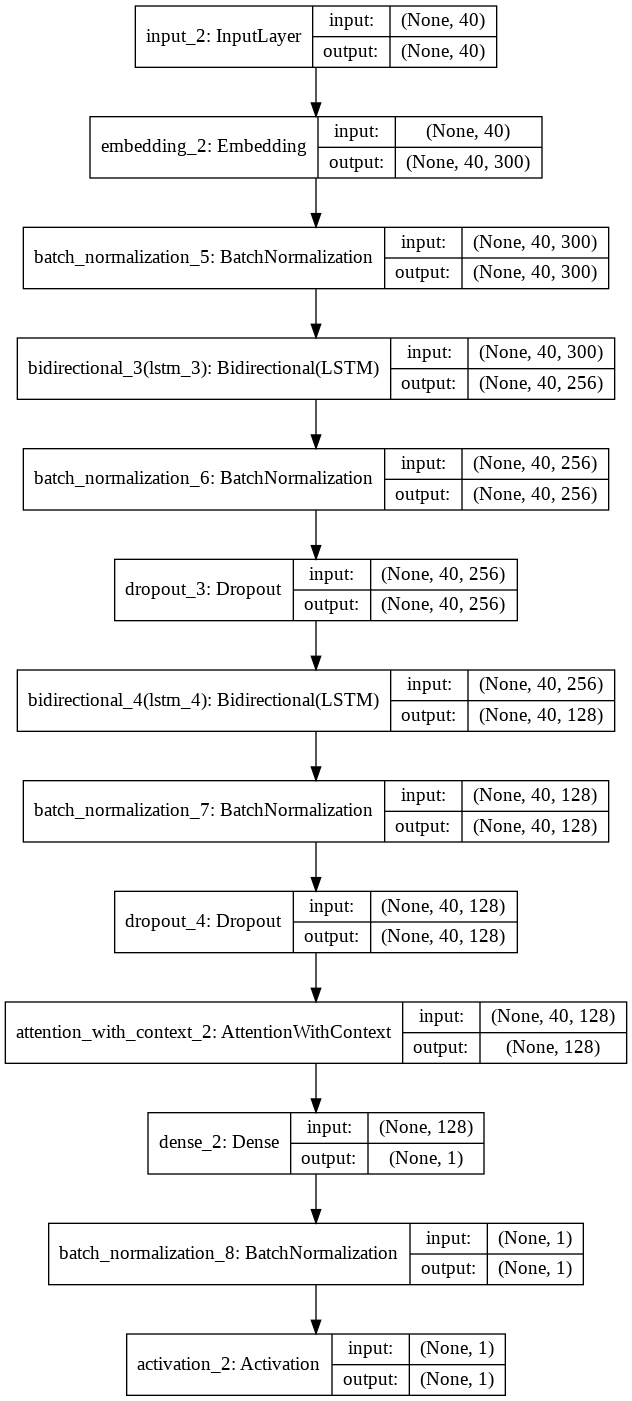

In [23]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [24]:

checkpoint_path ='/content/drive/My Drive/Project_' + str(NUM_TWEET) + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir="logs")

def train(x_train,y_train, x_val, y_val,
          epochs=15,
          beta_1 = 0.9, beta_2 = 0.999,
          batch_size = BATCH_SIZE,
          starter_lr = 1e-3):
    
    def scheduler(epoch):
        if epoch == 0:
            print(starter_lr)
            return starter_lr
        # elif epoch < 1:
        #     print(starter_lr * 1.2)
        #     return starter_lr * 1.2
        else:
            print(starter_lr * np.exp(0.25 * (1 - epoch)))
            return starter_lr * np.exp(0.25 * (1- epoch))

    
    lr_scheduler = LearningRateScheduler(scheduler)                                  
    opt = Adam(learning_rate=starter_lr, beta_1 = beta_1, beta_2 =beta_2)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    

    mc = ModelCheckpoint(checkpoint_path,   monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=True)
    
    #train the model
    history = model.fit(x_train, y_train, epochs=epochs,verbose=1, validation_data=(x_val, y_val),
                    callbacks=[es, mc, lr_scheduler, tensorboard_callback], batch_size = BATCH_SIZE)
    return history


In [26]:
%%time

history = train(x_train,y_train, x_val, y_val,
          epochs=20,
          beta_1 = 0.9, beta_2 = 0.999,
          batch_size = BATCH_SIZE,
          starter_lr = 1.5e-3)


KeyboardInterrupt: ignored

In [ ]:
%tensorboard --logdir logs

In [ ]:


checkpoint_path ='/content/drive/My Drive/Project_' + str(NUM_TWEET) + '.ckpt'

def prediction_on_testdata(x_test, y_test, checkpoint_path, start = 165, num_pred=40, long_thres = 20):
  def func(a):
      a = [pred[0] for pred in a]
      a = np.array(a).round()
      return a
  model.load_weights(checkpoint_path)
  predict = model.predict(x_test[start:start + num_pred])
  b = func(predict)
  predict = [pred[0] for pred in predict]
  long_error_count = 0
  short_error_count = 0
  long_count = 0
  positive_count = 0
  for i in range(num_pred):
    if y_test[start + i] == 1:
        positive_count += 1
    text_list = list(x_test_1[start + i].split())
    if len(text_list) > long_thres:      # count long tweet (> long_thres)accuracy
      long_count += 1
      if y_test[start + i] != b[i]:
        long_error_count += 1
    if len(text_list) <= long_thres:     # count short tweet (<= long_thres) accuracy
      if y_test[start + i] != b[i]:
        short_error_count += 1
    print(x_test_1[start + i] +'\n sentiment score; ' + str(y_test[start + i]) + '\n estimated score: ' + str(b[i]) + " | " + str(predict[i]))
    
  long_acc = 1 - long_error_count / long_count
  short_acc = 1 - short_error_count / (num_pred - long_count)
  print('There are {} positive tweets'.format(positive_count))

  print('{} percent of long (> {}) tweets are correctily classified.'.format(long_acc, long_thres))
  print('{} percent of short (<= {}) tweets are correctily classified.'.format(short_acc, long_thres))

prediction_on_testdata(x_test, y_test, checkpoint_path, start =0, num_pred=359, long_thres=25)


In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import (classification_report,
							 confusion_matrix)
model.load_weights(checkpoint_path)

def func(a):
        a = [pred[0] for pred in a]
        a = np.array(a).round()
        return a

def test(model, x_train, x_val, y_train, y_val):
    from sklearn.metrics import classification_report
    # train_report = classification_report(y_train, func(model.predict(x_train)), digits=4)
    val_report = classification_report(y_val, func(model.predict(x_val)), digits=4)
    test_report = classification_report(y_test, func(model.predict(x_test)), digits=4)
    # print("Sanity check. The report for classifying the training set")
    # print(train_report)
    print("The report for classifying the validation set")
    print(val_report)
    print("The report for classifying the test set")
    print(test_report)
    print()

test(model, x_train, x_val, y_train, y_val)



In [ ]:
def plot_cm(labels, predictions, data='test'):
    cm = confusion_matrix(y_true = labels, y_pred = predictions, normalize='true')
    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=['negative', 'positive'], yticklabels=['positive', 'negative'])
    plt.title("Confusion matrix ({})".format(data))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label") 
    plt.show()

def plot_history():
    # plot loss during training
    fig, _ = plt.subplots(nrows=2,ncols=1)
    fig.tight_layout(pad=2.5)
    plt.subplot(211)
    plt.title('Loss')
    # plt.plot(history_0.history['loss'] + history.history['loss'] , label='train')
    # plt.plot(history_0.history['val_loss'] + history.history['val_loss'], label='test')
    plt.plot(history.history['loss'] , label='train')
    
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    # plt.plot(history_0.history['accuracy'] + history.history['accuracy'], label='train')
    # plt.plot(history_0.history['val_accuracy'] + history.history['val_accuracy'], label='test')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')

    plt.legend()
    plt.show()


plot_cm(y_test, func(model.predict(x_test)), data='test')
plot_cm(y_val, func(model.predict(x_val)), data='validation')


plot_history()